In [1]:
from pipelines.custom_pipeline import cluster_custom, generate_ablation_sample
from datasets import load_dataset

ds = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/")
ds = ds["cleaned"]

README.md:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

data/cleaned-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/252k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/201583 [00:00<?, ? examples/s]

Generating cleaned split:   0%|          | 0/201583 [00:00<?, ? examples/s]

Generating sampled_1000 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating sampled_2000 split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating sampled_3000 split:   0%|          | 0/2988 [00:00<?, ? examples/s]

Generating sampled_4000 split:   0%|          | 0/3920 [00:00<?, ? examples/s]

Generating sampled_5000 split:   0%|          | 0/4840 [00:00<?, ? examples/s]

Generating sampled_6000 split:   0%|          | 0/5737 [00:00<?, ? examples/s]

Generating sampled_7000 split:   0%|          | 0/6617 [00:00<?, ? examples/s]

Generating sampled_8000 split:   0%|          | 0/7497 [00:00<?, ? examples/s]

Generating sampled_9000 split:   0%|          | 0/8365 [00:00<?, ? examples/s]

Generating sampled_10000 split:   0%|          | 0/9155 [00:00<?, ? examples/s]

Generating sampled_11000 split:   0%|          | 0/9906 [00:00<?, ? examples/s]

Generating sampled_12000 split:   0%|          | 0/10560 [00:00<?, ? examples/s]

Generating sampled_13000 split:   0%|          | 0/11120 [00:00<?, ? examples/s]

Generating sampled_14000 split:   0%|          | 0/11680 [00:00<?, ? examples/s]

Generating sampled_15000 split:   0%|          | 0/12213 [00:00<?, ? examples/s]

Generating sampled_16000 split:   0%|          | 0/12691 [00:00<?, ? examples/s]

Generating sampled_17000 split:   0%|          | 0/13131 [00:00<?, ? examples/s]

Generating sampled_18000 split:   0%|          | 0/13571 [00:00<?, ? examples/s]

Generating sampled_19000 split:   0%|          | 0/14011 [00:00<?, ? examples/s]

Generating sampled_20000 split:   0%|          | 0/14451 [00:00<?, ? examples/s]

Generating sampled_1000_labeled split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating sampled_2000_labeled split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating sampled_20000_labeled split:   0%|          | 0/14450 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [2]:
from datasets import Dataset

# 1. Convert to pandas
df = ds.to_pandas()

# 2. Drop duplicates
df = df.drop_duplicates(subset=["content"])

# 3. (NEW STEP) Reset the pandas index and drop the old one
df = df.reset_index(drop=True) 

# 4. Convert back. The __index_level_0__ column will not be created.
ds = Dataset.from_pandas(df)

In [3]:
randomly_selected_ds = ds.shuffle(42).select(range(100000))

In [4]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("indolem/indobertweet-base-uncased", cache_folder="cache/", trust_remote_code=True)
embeddings = sentence_model.encode(
    randomly_selected_ds["content"],
    batch_size=128,
    device="cuda",
    show_progress_bar=True,
    convert_to_numpy=True,
)

No sentence-transformers model found with name indolem/indobertweet-base-uncased. Creating a new one with mean pooling.


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [5]:
from pipelines.custom_pipeline import cluster_custom, generate_ablation_sample
reduced_embedding, cluster_labels, cluster_probabilties = cluster_custom(embeddings, seed=42, mode="dbcv")

Found intrinsic dimension of 23 with TwoNN
Running first stage UMAP
Running second stage UMAP
Tuning HDBSCAN with mode: 'dbcv'
  -> Using 'dbcv' mode (Bayesian Optimization on DBCV score)
Max raw distance to coredistance ratio: 1.8703941
Max raw distance to coredistance ratio: 1.9712576
Max raw distance to coredistance ratio: 1.9658515
Max raw distance to coredistance ratio: 1.9355555
Max raw distance to coredistance ratio: 2.1099832
Max raw distance to coredistance ratio: 1.3351386
Max raw distance to coredistance ratio: 1.9355555
Max raw distance to coredistance ratio: 2.1099832
Max raw distance to coredistance ratio: 1.3351386
Max raw distance to coredistance ratio: 1.9355555
Max raw distance to coredistance ratio: 1.327529
Max raw distance to coredistance ratio: 2.1099832
Max raw distance to coredistance ratio: 1.9712576
Max raw distance to coredistance ratio: 2.1099832
Max raw distance to coredistance ratio: 1.3351386
Max raw distance to coredistance ratio: 1.9355555
Max raw dista

In [6]:
from umap import UMAP
visual_reducer = UMAP(n_neighbors=20, n_components=2, metric="euclidean", min_dist=1, random_state=42)
visual_embeddings = visual_reducer.fit_transform(reduced_embedding)

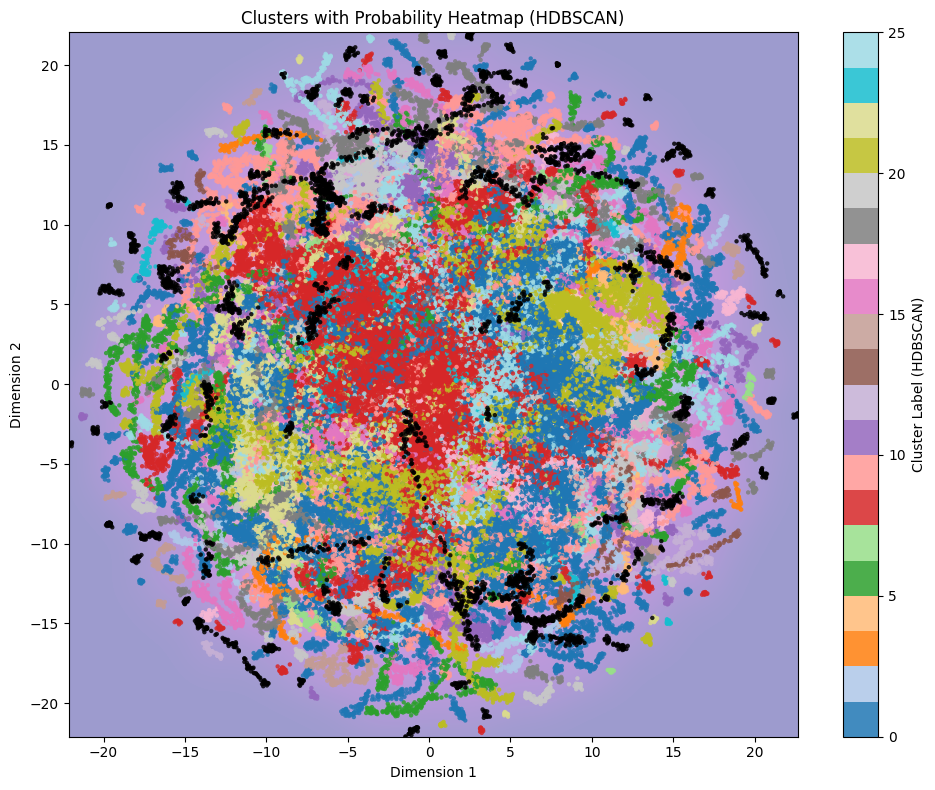

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_clusters_with_prob_heatmap(
    data_2d,
    cluster_labels,
    cluster_probabilities,
    cmap_clusters="tab10",
    cmap_heat="viridis",
    grid_res=200,
    s=10,
    alpha_points=0.85,
    noise_color="black",
):
    """
    Plot clusters in 2D with a soft heatmap of HDBSCAN probabilities underneath.
    
    Noise points (label = -1) are shown in black.
    """
    x, y = data_2d[:, 0], data_2d[:, 1]

    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, weights=cluster_probabilities)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, grid_res),
        np.linspace(ymin, ymax, grid_res)
    )

    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(
        zz,
        origin="lower",
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap_heat,
        alpha=0.4,
        aspect="auto",
    )

    
    clustered_mask = cluster_labels != -1
    noise_mask = cluster_labels == -1

    
    sc = ax.scatter(
        x[clustered_mask],
        y[clustered_mask],
        c=cluster_labels[clustered_mask],
        cmap=cmap_clusters,
        s=s,
        alpha=alpha_points,
        edgecolors="none",
    )

    
    ax.scatter(
        x[noise_mask],
        y[noise_mask],
        color=noise_color,
        s=s,
        alpha=alpha_points,
        edgecolors="none",
    )

    
    plt.colorbar(sc, ax=ax, label="Cluster Label (HDBSCAN)")
    ax.set_title("Clusters with Probability Heatmap (HDBSCAN)")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

    
plot_clusters_with_prob_heatmap(
    visual_embeddings,
    cluster_labels,
    cluster_probabilties,
    cmap_clusters="tab20",
    cmap_heat="plasma",
    grid_res=1000,
)

In [8]:
import numpy as np
unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
cluster_dict = dict(zip(unique_labels, label_counts))
print(cluster_dict)

{np.int64(-1): np.int64(4310), np.int64(0): np.int64(18470), np.int64(1): np.int64(4520), np.int64(2): np.int64(812), np.int64(3): np.int64(782), np.int64(4): np.int64(590), np.int64(5): np.int64(1395), np.int64(6): np.int64(2397), np.int64(7): np.int64(423), np.int64(8): np.int64(19632), np.int64(9): np.int64(6507), np.int64(10): np.int64(2203), np.int64(11): np.int64(498), np.int64(12): np.int64(526), np.int64(13): np.int64(513), np.int64(14): np.int64(701), np.int64(15): np.int64(1924), np.int64(16): np.int64(2064), np.int64(17): np.int64(1224), np.int64(18): np.int64(3995), np.int64(19): np.int64(3460), np.int64(20): np.int64(10183), np.int64(21): np.int64(1327), np.int64(22): np.int64(3979), np.int64(23): np.int64(1239), np.int64(24): np.int64(5572), np.int64(25): np.int64(754)}


In [10]:
from datasets import load_dataset
fresh_ds = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/")
for i in range(1000, 21000, 1000):
    sampled_dataset = generate_ablation_sample(randomly_selected_ds, cluster_labels, cluster_probabilties, i, seed=42, filter_mode="above_mean", inter_cluster_strategy="direct_proportion", intra_cluster_bias="confidence_prob")
    fresh_ds[f"sampled_{i}"] = sampled_dataset

Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 698.41it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 678.47it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 658.50it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 633.51it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 618.56it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 573.53it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 588.47it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 568.92it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 553.44it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 541.45it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 526.43it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 512.77it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 498.74it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 479.37it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 476.39it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 465.72it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 458.82it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 446.85it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 434.96it/s]


Applying Filter Mode: 'above_mean'
Calculating Inter-Cluster Strategy: 'direct_proportion'
Executing Intra-Cluster Bias: 'confidence_prob'


100%|██████████| 26/26 [00:00<00:00, 430.04it/s]


In [12]:
fresh_ds

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'related', 'confidence'],
        num_rows: 201583
    })
    cleaned: Dataset({
        features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'related', 'confidence'],
        num_rows: 201583
    })
    sampled_1000: Dataset({
        features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'related', 'confidence'],
        num_rows: 999
    })
    sampled_2000: Dataset({
        features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'related', 'confidence'],
        num_rows: 2002
    })
    sampled_3000: Dataset({
        features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'related', 'confidence'],


In [ ]:
from datasets import DatasetDict

# 1. Get the correct features (schema) from your 'cleaned' dataset
correct_features = fresh_ds['cleaned'].features

print(f"--- Correct Schema (from 'cleaned') ---")
print(correct_features)
print(f"\n--- Old 'sampled_1000' Features ---")
print(fresh_ds['sampled_1000'].features)

# 2. Cast each dataset *individually* by iterating through the dict
print("\nApplying schema correction to all splits...")
for split_name, dataset in fresh_ds.items():
    print(f"Casting '{split_name}'...")
    # --- THIS IS THE FIX ---
    fresh_ds[split_name] = dataset.cast(correct_features)

# (Alternative one-liner using dict comprehension)
# fresh_ds = DatasetDict({
#     name: ds.cast(correct_features) for name, ds in fresh_ds.items()
# })

# 3. Verify the change
print(f"\n--- Corrected 'sampled_1000' Features ---")
print(fresh_ds['sampled_1000'].features)

# 4. Now your push to hub will work
print("\nUploading to Hub...")
fresh_ds.push_to_hub("tianharjuno/twitter-parse", commit_description="Created subsamples for training")
print("Upload complete.")

--- Correct Schema (from 'cleaned') ---
{'tweet_id': Value(dtype='string', id=None), 'time': Value(dtype='string', id=None), 'author': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'comment_count': Value(dtype='int64', id=None), 'repost_count': Value(dtype='int64', id=None), 'like_count': Value(dtype='int64', id=None), 'view_count': Value(dtype='int64', id=None), 'related': Value(dtype='bool', id=None), 'confidence': Value(dtype='float64', id=None)}

--- Old 'sampled_1000' Features ---
{'tweet_id': Value(dtype='string', id=None), 'time': Value(dtype='string', id=None), 'author': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'comment_count': Value(dtype='int64', id=None), 'repost_count': Value(dtype='int64', id=None), 'like_count': Value(dtype='int64', id=None), 'view_count': Value(dtype='int64', id=None), 'related': Value(dtype='null', id=None), 'confidence': Value(dtype='float64', id=None)}

Applying schema correction to all sp

AttributeError: 'Dataset' object has no attribute 'cast_features'

In [11]:
fresh_ds.push_to_hub("tianharjuno/twitter-parse", commit_description="Created subsamples for training")

ValueError: All datasets in `DatasetDict` should have the same features but features for 'cleaned' and 'sampled_1000' don't match: {'tweet_id': Value(dtype='string', id=None), 'time': Value(dtype='string', id=None), 'author': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'comment_count': Value(dtype='int64', id=None), 'repost_count': Value(dtype='int64', id=None), 'like_count': Value(dtype='int64', id=None), 'view_count': Value(dtype='int64', id=None), 'related': Value(dtype='bool', id=None), 'confidence': Value(dtype='float64', id=None)} != {'tweet_id': Value(dtype='string', id=None), 'time': Value(dtype='string', id=None), 'author': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'comment_count': Value(dtype='int64', id=None), 'repost_count': Value(dtype='int64', id=None), 'like_count': Value(dtype='int64', id=None), 'view_count': Value(dtype='int64', id=None), 'related': Value(dtype='null', id=None), 'confidence': Value(dtype='float64', id=None)}